<a href="https://colab.research.google.com/github/alexDahersh/Data-Science-fund./blob/main/Alex_HershU7Proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
!pip install git+https://github.com/pydata/xarray.git
!pip install preliz
!pip install bambi

  Cloning https://github.com/pydata/xarray.git to /tmp/pip-req-build-f1yg5e3u
  Running command git clone --filter=blob:none --quiet https://github.com/pydata/xarray.git /tmp/pip-req-build-f1yg5e3u
  Resolved https://github.com/pydata/xarray.git to commit 0184702f16c3f744fc9096c7dac690626dcc6922
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for xarray: filename=xarray-2025.1.3.dev22+g0184702f-py3-none-any.whl size=1262235 sha256=18821091ddafc05ab3f29698ee87aaf2dca4df767546a9cfb16de98d30f94e34
  Stored in directory: /tmp/pip-ephem-wheel-cache-h86vjdiy/wheels/15/f9/46/ac58ec95d7761bd0b92f54d99c5d132719866f63745c3702ed
Successfully built xarray
  Attempting uninstall: xarray
    Found existing installation: xarray 2025.1.2
    Uninstalling xarray-2025.1.2:
      Successfully uninstalled xarray-2025.1.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 2.1 MB/s eta 0:00:00
   ━

In [ ]:
import preliz as pz
import bambi as bmb
import pymc as pm
import numpy as np
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt

# How Fat Are Our Chickens?

I'm going to be investigating how the weight of chickens, specifically broilers, change over time. Fatter chickens can be sold for more, so chicken owners have an incentive to make them fatter. I'm going to predict how quickly our chickens will be getting fatter in the next few years.

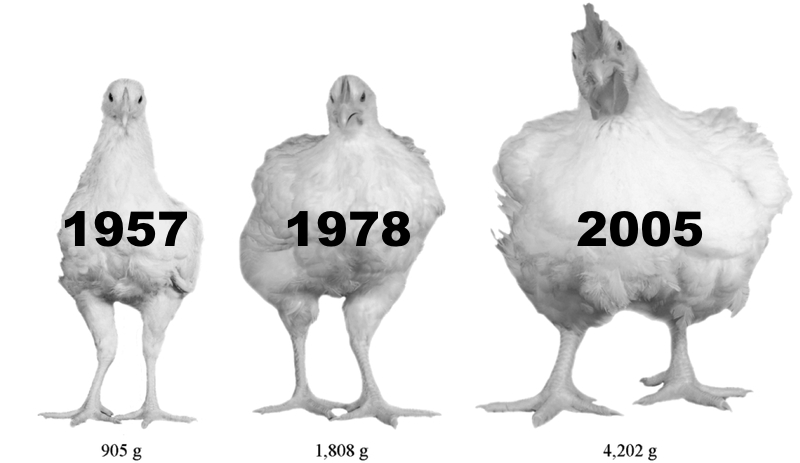

## Assumptions

I don't know much about chickens, so I won't have any very specific assumptions. I'm also going to use my little knowledge to assume weak priors will be best.

I'm going to assume the weight of a chicken one year is related to the weight of chickens previous years. How fat a chicken is should be a mix of genetics and how we raise them, and neither of these things should drastically change in a few years.

I'm going to assume the relationship between the weights of chickens different years is stronger when the year difference is smaller.

I'm going to assume the relantionship between year and weight is increasing and will continue to increase (assumption for my mean function).

## Priors and Likelihoods

I'm going to use a gaussian process for the mean because chicken weight is somewhat random and a gaussian process fits my assumptions that years are related. A gaussian process works better for predicting the next few years than a glm because it can pick up on recent trends. Our chicken fattening process is different nowadays than it was decades ago so predicting the next few years with stuff that happened decades ago doesn't make too much sense.

I'm going to use a squared exponential covariance function because of my assumption that years near each other should be more related.

My priors for my covariance function are going to be inverse gamma for ell and a half cauchy for alpha. I'm not too sure what ell and alpha stand for, but I'm using the weak prior for ell from the notes and a cauchy for alpha so high values are still possible.

I'm going to use a normal function for my likelihood. The gaussian process should give the most likely value for the mean and using a normal function keeps the value near the mean.

My prior for the mean function of the gaussian process will be a linear model. This should prevent the gaussian process from going directly to 0 after the data ends but shouldn't impact the next 10 or so years too much. While the true mean function probably isn't exactly linear, a linear approximation should work for the short term.

## Data

In [ ]:
chickens = pd.read_csv('https://raw.githubusercontent.com/alexDahersh/Data-Science-fund./refs/heads/main/Chicken%20Data%20-%20Sheet1.csv') #Loading my chickens

In [ ]:
chickens # looking at my chickens

,Year,Age,Weight,Feed_To_Meet_Gain,Mortality
0,1925,112.0,2.50,4.70,18.00
1,1935,98.0,2.86,4.40,14.00
2,1940,85.0,2.89,4.00,12.00
3,1945,84.0,3.03,4.00,10.00
4,1950,70.0,3.08,3.00,8.00
5,1955,70.0,3.07,3.00,7.00
6,1960,63.0,3.35,2.50,6.00
7,1965,63.0,3.48,2.40,6.00
8,1970,56.0,3.62,2.25,5.00
9,1975,56.0,3.76,2.10,5.00


There is quite a few data points from recent years so the predictions for the next few years should be good

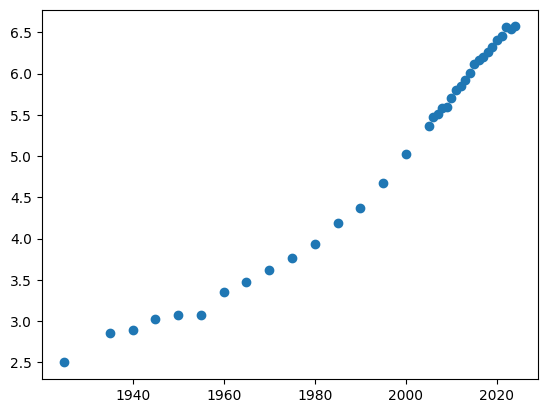

In [ ]:
plt.scatter(chickens["Year"], chickens["Weight"]) # plotting weight vs year

The above graph is weight vs years. As expected, weight increases from year to year. The increase seems to be slowing in the past decade, but not by too much. The most recent data points don't seem to be increasing but that is likely due to covid.

This graph meets my assumptions, so nothing wrong has happened so far. The graph is roughly linear with the first few observations being outliers so the mean function should work fine.

In [ ]:
def get_ig_params(x_vals, l_b=None, u_b=None, mass=0.96, plot=False): # I copied this from the notes. It follows my assumptions and gives a weak prior
    """
    Returns a weakly informative prior for the length-scale parameter of the GP kernel.
    """

    differences = np.abs(np.subtract.outer(x_vals, x_vals))
    if l_b is None:
        l_b = np.min(differences[differences != 0]) * 2
    if u_b is None:
        u_b = np.max(differences) / 1.5

    dist = pz.InverseGamma()
    pz.maxent(dist, l_b, u_b, mass, plot=plot)

    return dict(zip(dist.param_names, dist.params))

In [ ]:
t = chickens.Year.values[:,None] # I'm not sure what this does, but it makes everything work
y = chickens.Weight.values # I'm creating variables to make it easier to reference

## Model

In [ ]:
with pm.Model() as model_hsgp: # my model!
    #prior for our covariance function
    ℓ = pm.InverseGamma('ℓ', **get_ig_params(t))
    a = pm.HalfCauchy('a', .3) # .3 is very weak. That would be a pound every 3.3 years
    b = pm.Cauchy('b',-200,1000) # very weak. idk where intercept will end up

    #this is our kernal, which decides how our points relate to one another
    # it's a rational quadratic as I said so earlier
    cov = 1 * pm.gp.cov.ExpQuad(1, ls=ℓ)
    mean_func = pm.gp.mean.Linear(a,b)

    # I was going to use a HSGP but apparently pymc doesn't let a ratquad mix with a hsgp
    gp = pm.gp.HSGP(m=[10], c=10, cov_func=cov, mean_func = mean_func)

    #f is for function, as in the function we use to transform our data
    f = gp.prior('f', X=t)
    #prior for the variance binomial. It's a cauchy so it is weak
    α = pm.HalfCauchy('α', 1)
    #likelihood
    x = pm.Normal("y", mu=f, sigma=α, observed=y)

    idata_hsgp = pm.sample() # sampling

Output()

ERROR:pymc.stats.convergence:There were 52 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


The lines are red because red is a cool color!

I'm guessing the divergences are from the maximum tree depth. The model still turned out good and I trust it so I'll ignore the divergences.

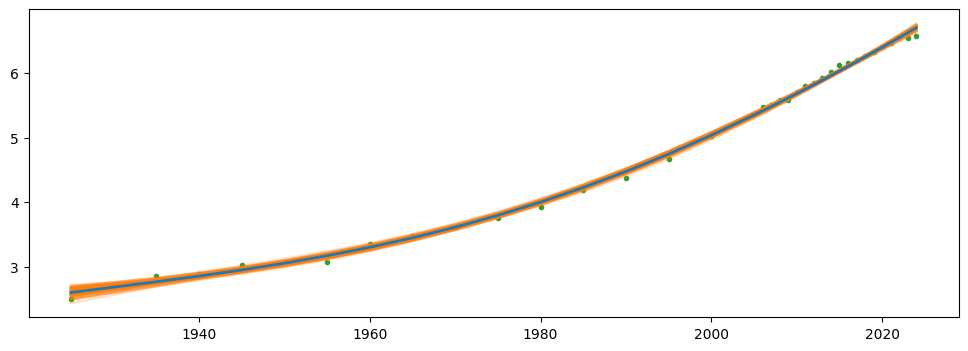

In [ ]:
_, ax = plt.subplots(1, 1, figsize=(12, 4)) # creates a plot and defines its size
#plot raw data
ax.plot(chickens["Year"].values, chickens["Weight"].values, "C2.")

#grab posterior
f = az.extract(idata_hsgp, group="posterior", var_names="f")


idx = np.argsort(chickens["Year"].values)
#plot samples of the posterior
ax.plot(chickens["Year"].values[idx], f.values[idx,:100], alpha=0.25, color="C1")
#plot posterior mean
ax.plot(chickens["Year"].values[idx], f.values[idx].mean(1), color="C0", lw=2)

This is the result of a gaussian process. There is enough data and it's smooth enough so the gaussian process did well. This isn't what I'm interested in though because I'm looking for future predictions.

In [ ]:
tnew = np.linspace(1900, 2120, 220) # taken from mauna loa article
with model_hsgp: # adding new data points to model
    fnew = gp.conditional("fnew", Xnew=tnew[:, None])

with model_hsgp: # making guesses for new data points
    ppc = pm.sample_posterior_predictive(idata_hsgp, var_names=["fnew"])

Output()

Text(0.5, 0, 'Year')

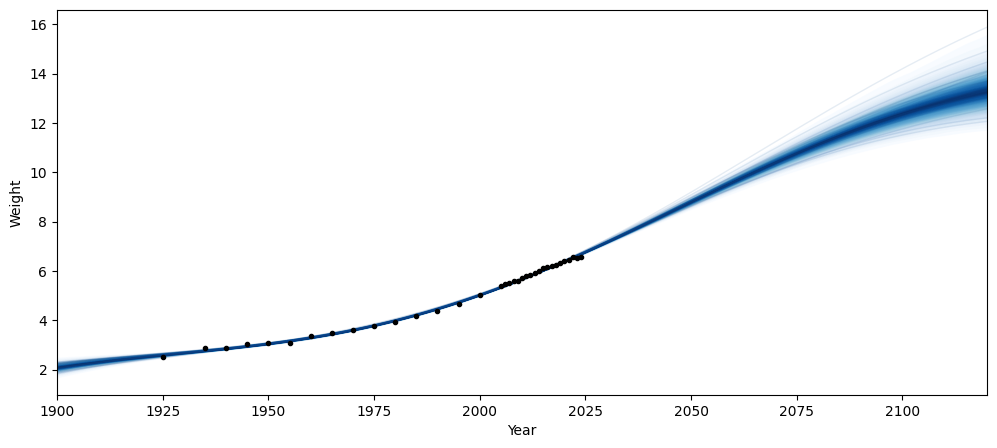

In [ ]:
samples = ppc.posterior_predictive["fnew"] # taken from mauna loa article

fig = plt.figure(figsize=(12, 5))
ax = plt.gca()
pm.gp.util.plot_gp_dist(ax, samples[0], tnew, plot_samples=True, palette="Blues") # function that plots a gp
ax.plot(t, y, "k.") # adding in actual data
ax.set_xlim([1900, 2120])
ax.set_ylabel("Weight")
ax.set_xlabel("Year")

The above graph is my model's predictions for the future. While the further out predictions will just follow the mean function, the closer predictions should be accurate. It's also interesting to see how prediction changes from predicting from recent years to the mean function around 2075. The model is predicting a steady growth in chicken weight in the next couple decades at a rate that's been faster than the average since 1920 (since the average rate is the mean function).

My prediction is that by 2050 our chickens will weight over 8 pounds.

# Conclusion

Our chickens will become balls soon. There is no sign that the rate of growth of chickens is slowing, and our chickens will breach the 10 pound mark in around 2075.

My gaussian process turned out good, and I trust its predictions for the next few years. I don't, however, predict its predictions for much further than that. My big takeaway is that gaussian processes don't seem to predict far out into the future too well since they just regress to the mean function.